## Import Libraries

In [ ]:
!pip install pythainlp
!pip install tensorboard
!pip install --upgrade pytorch-lightning
!pip -q install torch==1.5.0 torchtext==0.4.0 torchvision==0.6.0
!pip -q install transformers==3.5.0 thai2transformers==0.1.2

     |████████████████████████████████| 11.0MB 253kB/s 
     |████████████████████████████████| 747kB 43.0MB/s 
     |████████████████████████████████| 819kB 5.2MB/s 
     |████████████████████████████████| 10.6MB 15.4MB/s 
     |████████████████████████████████| 276kB 37.7MB/s 
     |████████████████████████████████| 112kB 45.9MB/s 
     |████████████████████████████████| 645kB 37.2MB/s 
     |████████████████████████████████| 829kB 39.4MB/s 
     |████████████████████████████████| 1.3MB 39.5MB/s 
     |████████████████████████████████| 296kB 44.5MB/s 
     |████████████████████████████████| 143kB 48.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=59463da7842556f9d66aa8f9858ef2fdc7b59786ec53b3cf9b4700875a4fea8c
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which 

In [ ]:
import ast
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pythainlp
import itertools
import os

from pythainlp.util import normalize
from transformers import pipeline, AutoTokenizer
from thai2transformers.tokenizers import ThaiWordsNewmmTokenizer
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
import keras
import keras.backend as k

from keras.preprocessing.sequence import pad_sequences 
from keras.models import *
from keras.layers import *
from keras.callbacks import *

## Load Dataset

In [ ]:
directory = './'

In [ ]:
def read_data(room):
  with open(directory + '1 Scrape Data/{}.txt'.format(room), encoding="utf8") as json_file:
    data = json.loads(json.load(json_file))
    df = pd.DataFrame(data)
    df = df[['title', 'tags']]
    return df

bangrak_df = read_data('bangrak')
beauty_df = read_data('beauty')
rajdumnern_df = read_data('rajdumnern')
religious_df = read_data('religious')
sinthorn_df = read_data('sinthorn')

In [ ]:
df = pd.concat([bangrak_df, beauty_df, rajdumnern_df, religious_df, sinthorn_df])
df.head()

,title,tags
0,หาเพื่อนคุยค่ะ,"[ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค..."
1,เราควรรู้สึกยังไงดี ?,[ประสบการณ์ความรัก]
2,LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่..."
3,รักข้างเดียว,"[ความรักวัยรุ่น, แอบรัก]"
4,ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,[ความรักวัยรุ่น]


## EDA

In [ ]:
all_tags = df['tags'].sum()
count_tags = Counter(all_tags).most_common()
count_tags

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3226),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1843),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 938),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 831),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 535),
 ('ทำผม', 535),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [ ]:
print('Amount of tags: ' + str(len(count_tags)))

Amount of tags: 2334


## Cleansing Words

In [ ]:
def cleansing_text(text):
  # ลบ puncutation
  text = re.sub(r'[\n\!\@\#\฿\$\%\?\^\&\*\(\)\[\]\{\}\;\:\,\.\/\?\|\`\_\\+\\\=\~\-\<\>\「\」]\“\”', '', text)

  # ลบ space
  text = re.sub(r'[\r\n]', '', text)

  # ลบ number (0-9)
  text = re.sub(r'[0-9]','',text)
  
  # ลบ number (๐-๙)
  text = re.sub(r'[๐-๙]','',text)

  return text

In [ ]:
df['cleansing'] = df['title'].apply(lambda x: cleansing_text(x))
df.head()

,title,tags,cleansing
0,หาเพื่อนคุยค่ะ,"[ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...",หาเพื่อนคุยค่ะ
1,เราควรรู้สึกยังไงดี ?,[ประสบการณ์ความรัก],เราควรรู้สึกยังไงดี ?
2,LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...",LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...
3,รักข้างเดียว,"[ความรักวัยรุ่น, แอบรัก]",รักข้างเดียว
4,ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,[ความรักวัยรุ่น],ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...


## Tokenize Words

Tokenize with pythainlp

In [ ]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n']
screening_words = stopwords + removed_words

def tokenize_word_with_pythainlp(sentence):
  words = pythainlp.word_tokenize(str(sentence), engine='newmm')
  words = [w for w in words if w not in screening_words and w.strip()]
  words = list(map(lambda x: normalize(x), words))
  return words

Tokenize with AutoTokenizer

In [ ]:
tokenizer_wangchanberta_uncased = AutoTokenizer.from_pretrained(
  f'airesearch/wangchanberta-base-att-spm-uncased',
  revision='main',
  model_max_length=416,
)

def tokenize_word_with_wangchangerta_uncased(sentence):
  words = tokenizer_wangchanberta_uncased(sentence)
  words = tokenizer_wangchanberta_uncased.convert_ids_to_tokens(words['input_ids'])
  words = [w.replace('▁', '') for w in words if w not in ['▁', '<unk>', '</s>', '<s>']]
  return words

Tokenize with ThaiWordsNewmmTokenizer

In [ ]:
tokenizer_wangchanberta_newmm = ThaiWordsNewmmTokenizer.from_pretrained(
  f'airesearch/wangchanberta-base-wiki-newmm',
  revision='main',
  model_max_length=416,
)

def tokenize_word_with_wangchangerta_newmm(sentence, tokenizer):
  words = tokenizer_wangchanberta_newmm(sentence)
  words = tokenizer_wangchanberta_newmm.convert_ids_to_tokens(words['input_ids'])
  words = [w for w in words if w not in ['<_>', '<unk>', '</s>', '<s>']]
  return words

In [ ]:
df['tokenized'] = df['cleansing'].apply(lambda x: tokenize_word_with_wangchangerta_uncased(x))
df.head()

,title,tags,cleansing,tokenized
0,หาเพื่อนคุยค่ะ,"[ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...",หาเพื่อนคุยค่ะ,"[หาเพื่อน, คุย, ค่ะ]"
1,เราควรรู้สึกยังไงดี ?,[ประสบการณ์ความรัก],เราควรรู้สึกยังไงดี ?,"[เราควร, รู้สึก, ยังไงดี, ?]"
2,LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...",LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ในสังคมไทย, ทําไม, ยังไม่, เปิดกว้าง, เหมือน,..."
3,รักข้างเดียว,"[ความรักวัยรุ่น, แอบรัก]",รักข้างเดียว,"[รัก, ข้างเดียว]"
4,ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,[ความรักวัยรุ่น],ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,"[ทําไม, ผู้ชาย, สมัยนี้, งี่เง่า, ขี้, น้อยใจ,..."


## Word to Vector

In [ ]:
feature_extractor = pipeline(
  task='feature-extraction',
  tokenizer=tokenizer_wangchanberta_uncased,
  # tokenizer=tokenizer_wangchanberta_newmm,
  model = f'airesearch/wangchanberta-base-att-spm-uncased',
  # model = f'airesearch/wangchanberta-base-wiki-newmm',
  revision = 'main'
)

def extract_last_k(token, last_k=3):
  hidden_states = feature_extractor(token)[0]
  last_k_layers = [hidden_states[i] for i in [-i for i in range(1, last_k + 1)]]
  cat_hidden_states = sum(last_k_layers, [])
  return np.array(cat_hidden_states)

In [ ]:
def get_word_list(series):
  words = list(itertools.chain(*series.to_list()))
  words = set(words)
  return words

tokenized_word_list = get_word_list(df['tokenized'])

In [ ]:
def get_word_vectors(tokenized_word_list):
  ### Create word vectors and indices for word embedding layer
  word_index = {}
  word_vectors = []

  for index, w in enumerate(tokenized_word_list):
    word_index[w] = index
    word_vectors.append(extract_last_k(w))

  if '' not in word_index:
    word_index[''] = index + 1
    word_vectors.append(np.zeros(len(word_vectors[0])))

  return word_index, word_vectors

# word_index, word_vectors = get_word_vectors(tokenized_word_list)

In [ ]:
def write_pickle():
  with open(directory + '2 Pickle/word_index_wangchanberta-base-att-spm-uncased.pckl', 'wb') as f:
    pickle.dump(word_index, f)

  with open(directory + '2 Pickle/word_vectors_wangchanberta-base-att-spm-uncased.pckl', 'wb') as f:
    pickle.dump(word_vectors, f)

def read_pickle():
  with open(directory + '2 Pickle/word_index_wangchanberta-base-att-spm-uncased.pckl', 'rb') as f:
    word_index = pickle.load(f)

  with open(directory + '2 Pickle/word_vectors_wangchanberta-base-att-spm-uncased.pckl', 'rb') as f:
    word_vectors = pickle.load(f)

  return word_index, word_vectors

# write_pickle()
word_index, word_vectors = read_pickle()

## Prepare tags

Finding a suitable sequence length

In [ ]:
df['tokenized_count'] = df['tokenized'].apply(lambda x: len(x))
df.head()

,title,tags,cleansing,tokenized,tokenized_count
0,หาเพื่อนคุยค่ะ,"[ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...",หาเพื่อนคุยค่ะ,"[หาเพื่อน, คุย, ค่ะ]",3
1,เราควรรู้สึกยังไงดี ?,[ประสบการณ์ความรัก],เราควรรู้สึกยังไงดี ?,"[เราควร, รู้สึก, ยังไงดี, ?]",4
2,LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...",LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างป...,"[ในสังคมไทย, ทําไม, ยังไม่, เปิดกว้าง, เหมือน,...",8
3,รักข้างเดียว,"[ความรักวัยรุ่น, แอบรัก]",รักข้างเดียว,"[รัก, ข้างเดียว]",2
4,ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,[ความรักวัยรุ่น],ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู...,"[ทําไม, ผู้ชาย, สมัยนี้, งี่เง่า, ขี้, น้อยใจ,...",14


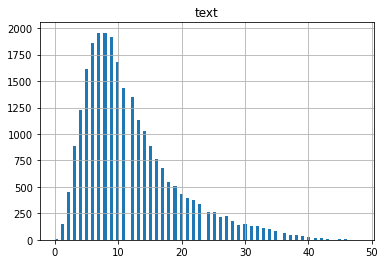

count    25800.000000
mean        11.941357
std          7.441372
min          0.000000
25%          7.000000
50%         10.000000
75%         15.000000
max         48.000000
Name: tokenized_count, dtype: float64


In [ ]:
# finding a suitable sequence length
# populate the list with length of the questions

length_df = pd.DataFrame({'text': df['tokenized_count']})
length_df.hist(bins=100)
plt.show()
print(df['tokenized_count'].describe())

Finding most common tags

In [ ]:
freq= {}
for i in df['tags']:
  for j in i:
    if j in freq.keys():
      freq[j] = freq[j] + 1
    else:
      freq[j] = 1

len(freq)

2334

In [ ]:
tag_freq = np.array(list(freq.values()))
print(tag_freq.mean())
print(tag_freq.std())

33.54198800342759
175.81438051159753


In [ ]:
freq = dict(sorted(freq.items(), key=lambda x:x[1], reverse=True))
common_tags = list(freq.keys())[:200]

In [ ]:
list(freq.items())[:200]

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3226),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1843),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 938),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 831),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 535),
 ('ทำผม', 535),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [ ]:
def common_tags_exis(tags_list):
  for tag in tags_list:
    if tag in common_tags:
      return True
  return False

In [ ]:
filter_common_df = df[df['tags'].apply(common_tags_exis)]
filter_common_df["common_tags"] = filter_common_df['tags'].apply(lambda x: list(filter(lambda x: x in common_tags, x)))
print(filter_common_df['common_tags'])
print(filter_common_df.shape)

0       [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ค...
1                                     [ประสบการณ์ความรัก]
2       [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่...
3                                [ความรักวัยรุ่น, แอบรัก]
4                                        [ความรักวัยรุ่น]
                              ...                        
5145                                               [หุ้น]
5146    [หุ้น, บริษัทหลักทรัพย์, ตลาดหลักทรัพย์, กองทุ...
5147                                           [การลงทุน]
5148                  [สินเชื่อเพื่อที่อยู่อาศัย, ธนาคาร]
5149    [ตลาดหลักทรัพย์, หุ้น, การลงทุน, ตลาดหลักทรัพย...
Name: common_tags, Length: 25771, dtype: object
(25771, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Parse tags to dummy variables

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filter_common_df['common_tags'])
y.shape

(25771, 200)

Save Dataframe to csv

In [ ]:
filter_common_df.to_csv(directory + '3 Output/filter_common.csv')

## Train, Test Split

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(filter_common_df['tokenized'], y, test_size=0.2, random_state=0, shuffle=True)
print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(20616,) (20616, 200)
(5155,) (5155, 200)


## Pad Sequences

In [ ]:
max_len = 10

In [ ]:
# custom texts to sequences
def texts_to_sequences(text_list):
  sequences = []
  for text in text_list:
    temp_list = []
    for word in text:
      temp_list.append(word_index[word]) if word in word_index else 0 # ignore unknown words
    sequences.append(temp_list)
  return sequences

In [ ]:
x_tr_seq = texts_to_sequences(x_tr)
x_val_seq = texts_to_sequences(x_val)

x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len, value=word_index[''])
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len, value=word_index[''])
print(x_tr_seq.shape)
print(x_val_seq.shape)
print('Example of pading: ' + str(x_tr_seq[0]))

(20616, 10)
(5155, 10)
Example of pading: [ 4869 10061 15878 11006  6375 16299 16299 16299 16299 16299]


## Deep Learning Model

In [ ]:
num_words = len(word_index)
num_labels = y.shape[1]
num_embedding_dim = len(word_vectors[0])
num_words, num_labels, num_embedding_dim

(16300, 200, 2304)

In [ ]:
def plot_model_loss(history, name):
  plt.figure(figsize=(12, 6))
  plt.plot(history['loss'], linewidth=2, label='Train')
  plt.plot(history['val_loss'], linewidth=2, label='Test')
  plt.legend(loc='upper right')
  plt.title(name)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

In [ ]:
def train_model(model, name):
  model.compile(optimizer='adam', loss='binary_crossentropy')
  mc = ModelCheckpoint(f"{name}-max-weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  his = model.fit(x_tr_seq, y_tr, batch_size=128, epochs=50, verbose=1, validation_data=(x_val_seq, y_val), callbacks=[mc])
  return his.history

Pause before train models

In [ ]:
assert True == False

AssertionError: ignored

#### Simple RNN

In [ ]:
def create_simple_RNN_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(SimpleRNN(128, return_sequences=True))
  model.add(SimpleRNN(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  return model

In [ ]:
rnn_history = []

if os.path.isfile(directory + '2 Pickle/rnn_model.h5'):
  rnn_model = keras.models.load_model(directory + '2 Pickle/rnn_model.h5')
else:
  rnn_model = create_simple_RNN_model()
  rnn_history = train_model(rnn_model, 'rnn')
  rnn_model.load_weights("rnn-max-weights.best.hdf5")
  rnn_model.save(directory + '2 Pickle/rnn_model.h5')

In [ ]:
rnn_model.summary()

In [ ]:
plot_model_loss(rnn_history, 'RNN')

#### LSTM

In [ ]:
def create_LSTM_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  return model

In [ ]:
lstm_history = []

if os.path.isfile(directory + '2 Pickle/lstm_model.h5'):
  lstm_model = keras.models.load_model(directory + '2 Pickle/lstm_model.h5')
else:
  lstm_model = create_LSTM_model()
  lstm_history = train_model(lstm_model, 'lstm')
  lstm_model.load_weights("lstm-max-weights.best.hdf5")
  lstm_model.save(directory + '2 Pickle/lstm_model.h5')

In [ ]:
lstm_model.summary()

In [ ]:
plot_model_loss(lstm_history, 'LSTM')

#### GRU

In [ ]:
def create_GRU_model():
  # define model architecture
  k.clear_session()

  #sequential model
  model = Sequential()

  #embedding layer
  model.add(Embedding(num_words,
                      output_dim=num_embedding_dim,
                      weights = [np.array(word_vectors)],
                      input_length=max_len,
                      mask_zero=False,
                      trainable=False))

  #lstm 
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(128))

  #dense layer
  model.add(Dense(1024, activation='relu')) 
  model.add(Dropout(0.5))

  #output layer
  model.add(Dense(num_labels ,activation='sigmoid'))

  return model

In [ ]:
gru_history = []

if os.path.isfile(directory + '2 Pickle/gru_model.h5'):
  gru_model = keras.models.load_model(directory + '2 Pickle/gru_model.h5')
else:
  gru_model = create_GRU_model()
  gru_history = train_model(gru_model, 'gru')
  gru_model.load_weights("gru-max-weights.best.hdf5")
  gru_model.save(directory + '2 Pickle/gru_model.h5')

In [ ]:
gru_model.summary()

In [ ]:
plot_model_loss(gru_history, 'gru_history')

## Predict

In [ ]:
def classify(pred_prob, thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [ ]:
def find_optimum_threshold(model):
  score=[]

  pred_prob = model.predict(x_val_seq)

  #define candidate threshold values
  threshold = np.arange(0, 0.5, 0.01)

  #convert to 1 array
  y_true = np.array(y_val).ravel() 

  for thresh in threshold:
    #classes for each threshold
    y_pred_seq = classify(pred_prob,thresh) 

    #convert to 1d array
    y_pred = np.array(y_pred_seq).ravel()

    score.append(metrics.f1_score(y_true,y_pred))

  opt = threshold[score.index(max(score))]
  return opt

In [ ]:
def print_report(model, threshold=0.24):
  pred_prob = model.predict(x_val_seq)
  y_true = np.array(y_val).ravel()
  y_pred_seq = classify(pred_prob, threshold)
  y_pred = np.array(y_pred_seq).ravel()
  print(metrics.classification_report(y_true, y_pred))

In [ ]:
def compare_actual_predictions(model, name, threshold=0.24):
  pred_prob = model.predict(x_val_seq)
  y_pred_seq = classify(pred_prob, threshold)
  y_pred = mlb.inverse_transform(np.array(y_pred_seq))
  y_true = mlb.inverse_transform(np.array(y_val))
  prediction_df = pd.DataFrame({'comment':x_val,'actual':y_true,'predictions':y_pred})
  prediction_df.to_csv(directory + f'3 Output/prediction-{name}.csv')
  return prediction_df

In [ ]:
def predict_tag(model, comment, opt=0.24):  
  text=[]  
  text = [cleansing_text(comment)]
  text = [tokenize_word_with_wangchangerta_uncased(comment)]
  #seq = x_tokenizer.texts_to_sequences(text)
  seq = texts_to_sequences(text)

  pad_seq = pad_sequences(seq,  padding='post', maxlen=max_len, value=word_index[''])
  pred_prob = model.predict(pad_seq)
  classes = classify(pred_prob,opt)[0]
  classes = np.array([classes])
  classes = mlb.inverse_transform(classes)  
  return classes

In [ ]:
topics = [
  "ขอถามความหมายของคำบาลีค่ะ",
  "ทั่วสากลจักรวาล มีพระพุทธเจ้ามากมาย ดั่งเม็ดทรายในจักรวาล",
  "วิ่งแล้วน่องใหญ่จริงไหม",
  "แอบรักผู้ชายข้างบ้าน ทำยังไงดี​",
  "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ",
  "ไปทำบุญที่ไหนดี"
]

#### Simple RNN

In [ ]:
rnn_threshold = find_optimum_threshold(rnn_model)
rnn_threshold

0.14

In [ ]:
print_report(rnn_model, rnn_threshold)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017665
           1       0.28      0.31      0.29     13335

    accuracy                           0.98   1031000
   macro avg       0.63      0.65      0.64   1031000
weighted avg       0.98      0.98      0.98   1031000



In [ ]:
compare_actual_predictions(rnn_model, 'rnn', rnn_threshold)

,comment,actual,predictions
2172,"[ข่าว, ดี้, ดี, ., นายกฯ, นําทีม, ถ่ายภาพ, ประ...","(รัฐบาล,)","(การเมือง, ข่าวเศรษฐกิจ, พรรคเพื่อไทย, รัฐบาล,..."
3591,"[เหมียน, เดิม, ---, มิ, ., ย, ., ปลายปี, ---]","(TFEX (Thailand Future Exchange), Technical An...","(การเมือง, รัฐบาล, หุ้น)"
2822,"[:, in, ปิดกิจการ, -, ตกงาน, เพียบ, /, ส, ป, า...","(การเมือง, ข่าวเศรษฐกิจ, นักการเมือง, พรรคก้าว...","(การเมือง, ข่าวเศรษฐกิจ, รัฐบาล, โรคติดเชื้อไว..."
2419,"[แฟน, ชอบ, พูด, ประชด, ว่าเป็น, คุณ, นาย, คุณ,...","(ครอบครัว, ประสบการณ์ชีวิตคู่, ปัญหาความรัก, ป...",()
2378,"[ปัจจุบัน, การ, เสริม, ซี, เมนต์, ใน, กระดูกสั...","(คลินิกความงาม, วิทยาศาสตร์)",()
...,...,...,...
3432,"[จาก, รังสิต, ไป, วัด, สัก, ใหญ่, นนทบุรี, ไป,...","(วัด,)","(ปฏิบัติธรรม, พระไตรปิฎก, ศาสนา, ศาสนาพุทธ)"
1714,"[เธอบอกว่า, กลัว, คน, มอง, ไม่ดี, เพราะว่า, กล...","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ปัญหาความรัก)","(ความรักวัยทำงาน, ความรักวัยรุ่น, ประสบการณ์คว..."
794,"[ตามหา, สบู่, !!!]","(ความงาม,)","(ความงาม,)"
1935,"[แอป, ธนาคาร, กรุงเทพ, พ, พ, พ, พ, พ]","(ธนาคาร, ธนาคารกรุงเทพ)","(ธนาคาร, หุ้น)"


In [ ]:
for t in topics:
  print(predict_tag(rnn_model, t, rnn_threshold))

[('ศาสนาพุทธ',)]
[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'ศาสนา', 'ศาสนาพุทธ')]
[('ปัญหาความรัก',)]
[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ประสบการณ์ชีวิตคู่', 'ปัญหาความรัก', 'ศาลาคนเศร้า')]
[('การลงทุน', 'หุ้น')]
[()]


#### LSTM

In [ ]:
lstm_threshold = find_optimum_threshold(lstm_model)
lstm_threshold

0.19

In [ ]:
print_report(lstm_model, lstm_threshold)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017665
           1       0.35      0.38      0.36     13335

    accuracy                           0.98   1031000
   macro avg       0.67      0.68      0.68   1031000
weighted avg       0.98      0.98      0.98   1031000



In [ ]:
compare_actual_predictions(lstm_model, 'lstm', lstm_threshold)

,comment,actual,predictions
2172,"[ข่าว, ดี้, ดี, ., นายกฯ, นําทีม, ถ่ายภาพ, ประ...","(รัฐบาล,)","(กระทรวงสาธารณสุข, การเมือง, รัฐบาล, วัคซีน (V..."
3591,"[เหมียน, เดิม, ---, มิ, ., ย, ., ปลายปี, ---]","(TFEX (Thailand Future Exchange), Technical An...","(การลงทุน, หุ้น)"
2822,"[:, in, ปิดกิจการ, -, ตกงาน, เพียบ, /, ส, ป, า...","(การเมือง, ข่าวเศรษฐกิจ, นักการเมือง, พรรคก้าว...","(การเมือง, ข่าวเศรษฐกิจ, พรรคเพื่อไทย, สิทธิมน..."
2419,"[แฟน, ชอบ, พูด, ประชด, ว่าเป็น, คุณ, นาย, คุณ,...","(ครอบครัว, ประสบการณ์ชีวิตคู่, ปัญหาความรัก, ป...","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์..."
2378,"[ปัจจุบัน, การ, เสริม, ซี, เมนต์, ใน, กระดูกสั...","(คลินิกความงาม, วิทยาศาสตร์)","(ความงาม,)"
...,...,...,...
3432,"[จาก, รังสิต, ไป, วัด, สัก, ใหญ่, นนทบุรี, ไป,...","(วัด,)",()
1714,"[เธอบอกว่า, กลัว, คน, มอง, ไม่ดี, เพราะว่า, กล...","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ปัญหาความรัก)","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์..."
794,"[ตามหา, สบู่, !!!]","(ความงาม,)","(ประสบการณ์ความรัก, ปัญหาความรัก)"
1935,"[แอป, ธนาคาร, กรุงเทพ, พ, พ, พ, พ, พ]","(ธนาคาร, ธนาคารกรุงเทพ)","(ธนาคาร, ธนาคารกสิกรไทย, บัตรเครดิต)"


In [ ]:
for t in topics:
  print(predict_tag(lstm_model, t, lstm_threshold))

[('ความงาม',)]
[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'ศาสนาพุทธ')]
[('Skin Care', 'ความงาม', 'สิว', 'เครื่องสำอาง')]
[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก', 'ศาลาคนเศร้า', 'แอบรัก')]
[('การลงทุน', 'ตลาดหลักทรัพย์', 'หุ้น')]
[('พิธีกรรมทางศาสนา', 'วัด', 'ศาสนา', 'ศาสนาคริสต์', 'ศาสนาพุทธ')]


#### GRU

In [ ]:
gru_threshold = find_optimum_threshold(gru_model)
gru_threshold

0.2

In [ ]:
print_report(gru_model, gru_threshold)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017665
           1       0.37      0.34      0.36     13335

    accuracy                           0.98   1031000
   macro avg       0.68      0.67      0.67   1031000
weighted avg       0.98      0.98      0.98   1031000



In [ ]:
compare_actual_predictions(gru_model, 'gru', gru_threshold)

,comment,actual,predictions
2172,"[ข่าว, ดี้, ดี, ., นายกฯ, นําทีม, ถ่ายภาพ, ประ...","(รัฐบาล,)","(กระทรวงสาธารณสุข, การเมือง, รัฐบาล, วัคซีน (V..."
3591,"[เหมียน, เดิม, ---, มิ, ., ย, ., ปลายปี, ---]","(TFEX (Thailand Future Exchange), Technical An...","(หุ้น,)"
2822,"[:, in, ปิดกิจการ, -, ตกงาน, เพียบ, /, ส, ป, า...","(การเมือง, ข่าวเศรษฐกิจ, นักการเมือง, พรรคก้าว...","(การเมือง, ข่าวเศรษฐกิจ, พรรคเพื่อไทย, รัฐบาล,..."
2419,"[แฟน, ชอบ, พูด, ประชด, ว่าเป็น, คุณ, นาย, คุณ,...","(ครอบครัว, ประสบการณ์ชีวิตคู่, ปัญหาความรัก, ป...","(การเมือง,)"
2378,"[ปัจจุบัน, การ, เสริม, ซี, เมนต์, ใน, กระดูกสั...","(คลินิกความงาม, วิทยาศาสตร์)","(คลินิกความงาม, ความงาม, ศัลยกรรมความงาม)"
...,...,...,...
3432,"[จาก, รังสิต, ไป, วัด, สัก, ใหญ่, นนทบุรี, ไป,...","(วัด,)","(ทำบุญ, วัด, ศาสนาพุทธ)"
1714,"[เธอบอกว่า, กลัว, คน, มอง, ไม่ดี, เพราะว่า, กล...","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ปัญหาความรัก)","(ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์..."
794,"[ตามหา, สบู่, !!!]","(ความงาม,)",()
1935,"[แอป, ธนาคาร, กรุงเทพ, พ, พ, พ, พ, พ]","(ธนาคาร, ธนาคารกรุงเทพ)","(การเงิน, ธนาคาร, บัตรเครดิต)"


In [ ]:
for t in topics:
  print(predict_tag(gru_model, t, gru_threshold))

[('ศาสนาพุทธ',)]
[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'ศาสนา', 'ศาสนาพุทธ')]
[('Skin Care', 'คลินิกความงาม', 'ความงาม', 'ศัลยกรรมความงาม')]
[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก', 'แอบรัก')]
[('หุ้น',)]
[()]


In [ ]:
t = 'ไปทำบุญที่ไหนดี'
print(predict_tag(rnn_model, t, rnn_threshold))
print(predict_tag(lstm_model, t, lstm_threshold))
print(predict_tag(gru_model, t, gru_threshold))

[()]
[('พิธีกรรมทางศาสนา', 'วัด', 'ศาสนา', 'ศาสนาคริสต์', 'ศาสนาพุทธ')]
[()]
